<a href="https://colab.research.google.com/github/TheDenk/images_mixing/blob/main/jupyters/colab_example_images_mixing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/TheDenk/images_mixing.git
!pip install -r ./images_mixing/requirements.txt > /dev/null

fatal: destination path 'images_mixing' already exists and is not an empty directory.


## Imports

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('./images_mixing')

import torch
import open_clip
from PIL import Image
from open_clip import SimpleTokenizer
from diffusers import DiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPModel

from utils import show_images

## Load additional models: CLIP and CoCa

In [3]:
feature_extractor = CLIPFeatureExtractor.from_pretrained(
    "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
)
clip_model = CLIPModel.from_pretrained(
    "laion/CLIP-ViT-B-32-laion2B-s34B-b79K", torch_dtype=torch.float16
)
coca_model = open_clip.create_model('coca_ViT-L-14', pretrained='laion2B-s13B-b90k').to('cuda')
coca_model.dtype = torch.float16
coca_transform = open_clip.image_transform(
    coca_model.visual.image_size,
    is_train = False,
    mean = getattr(coca_model.visual, 'image_mean', None),
    std = getattr(coca_model.visual, 'image_std', None),
)
coca_tokenizer = SimpleTokenizer()

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


## Create DiffusionPipeline from local .py file

In [4]:
mixing_pipeline = DiffusionPipeline.from_pretrained(
    # "stabilityai/stable-diffusion-2-base",
    "CompVis/stable-diffusion-v1-4",
    custom_pipeline="./images_mixing/images_mixing.py",
    clip_model=clip_model,
    feature_extractor=feature_extractor,
    coca_model=coca_model,
    coca_tokenizer=coca_tokenizer,
    coca_transform=coca_transform,
    torch_dtype=torch.float16,
)
mixing_pipeline = mixing_pipeline.to("cuda")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


## Generate

| Content prompt: abyssinians | Style prompt: whole wheat bread isolated on a white background |


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


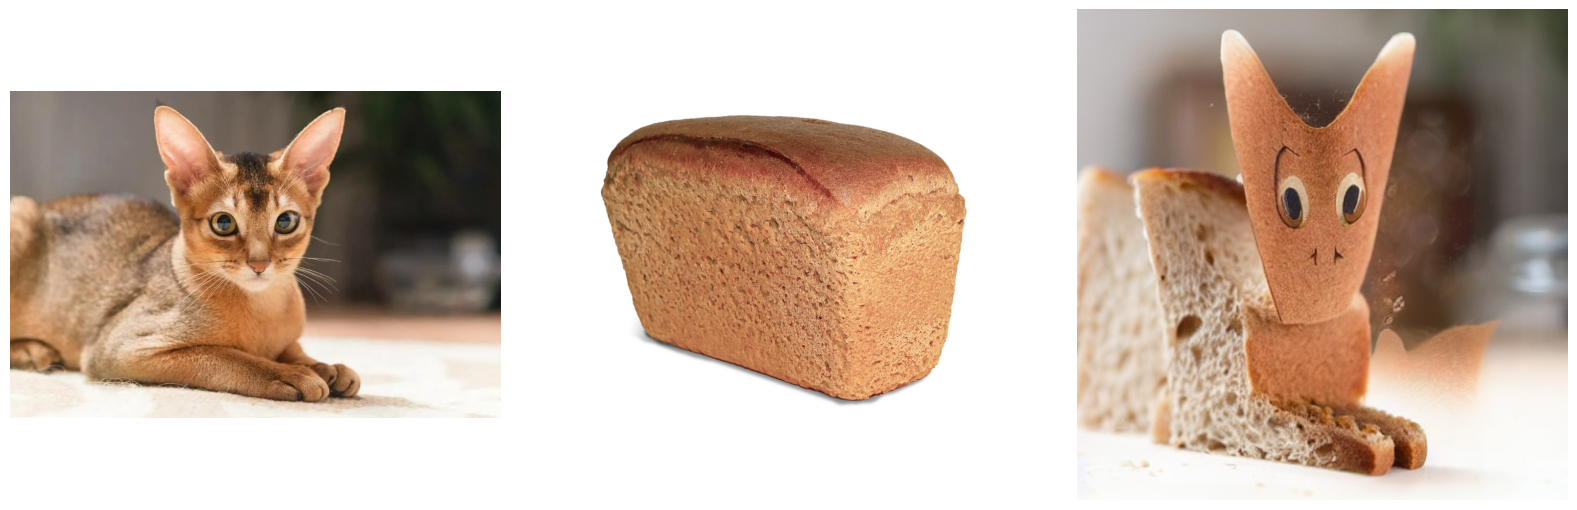

In [5]:
generator = torch.Generator(device="cuda").manual_seed(17)

content_image = Image.open('./images_mixing/images/cat.jpeg').convert("RGB")
style_image = Image.open('./images_mixing/images/bread.png').convert("RGB")

pipe_images = mixing_pipeline(
    num_inference_steps=50,
    content_image=content_image,
    style_image=style_image,
    content_prompt=None,  # If None will be automaticly created with CoCa
    style_prompt=None,  # If None will be automaticly created with CoCa
    noise_strength=0.4,  # Noise for start point (content image). More noise - more new information.
    slerp_latent_style_strength=0.25,  # Amount Style image information for start point
    slerp_prompt_style_strength=0.99,  # Amount Style prompt information for diffusion steps
    slerp_clip_image_style_strength=0.9,  # Amount Style image information for diffusion steps
    guidance_scale=9.0,
    batch_size=1,
    clip_guidance_scale=100,
    generator=generator,
    print_promts=True,
).images

show_images([content_image, style_image, pipe_images[0]], figsize=(16, 8))